In [1]:
import tensorflow as tf
%pylab inline
import pickle

import itertools
import os
import pandas as pd

import networkx as nx
import umap
from scipy import stats

Populating the interactive namespace from numpy and matplotlib


In [2]:
tf.config.threading.set_intra_op_parallelism_threads(36)
tf.config.threading.set_inter_op_parallelism_threads(36)

In [3]:
# %env CUDA_VISIBLE_DEVICES=0
# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#     try:
#     # Currently, memory growth needs to be the same across GPUs
#         for gpu in gpus:
#             tf.config.experimental.set_memory_growth(gpu, True)
#         logical_gpus = tf.config.experimental.list_logical_devices('GPU')
#         print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
#     except RuntimeError as e:
#     # Memory growth must be set before GPUs have been initialized
#         print(e)

In [4]:
import hosgns_walks
from utils import *

In [5]:
# preprocess dataset
dataset = 'OpenABM-Covid19-Interactions-5k-20'
AGGR_TIME = 1
partial_times, s_temp_net, df_tnet = load_temp_data(dataset, AGGR_TIME)

In [6]:
# rename nodes and time slices
map_node_index = {node:index for index, node in \
                  enumerate(np.unique(s_temp_net.reset_index()[['i', 'j']].values.flatten()))}
map_time_index = {time:index for index, time in \
                  enumerate(np.unique(s_temp_net.reset_index().tslice.values))}
NR_NODES = len(map_node_index)
NR_TIMES = len(map_time_index)

df_tnet['tslice'] = df_tnet['tslice'].map(map_time_index) 
df_tnet['i'] = df_tnet['i'].map(map_node_index) 
df_tnet['j'] = df_tnet['j'].map(map_node_index)

In [7]:
# load network and default list of active nodes
supra_G = pickle.load(open('../preprocessed/SupraAdjacencyMatrix/%s/Dyn/Aggtime%dWeight1ReptimeNon.gpickle' % (dataset, AGGR_TIME), 'rb'))
pat_active_time = pickle.load(open('../preprocessed/SupraAdjacencyMatrix/%s/PatActiveTimeAggtime%d.pkl'% (dataset,AGGR_TIME), 'rb'))
node_active_time = np.array([str(map_node_index[int(n_node.split('-')[0])])+'-'+\
                                 str(map_time_index[int(n_node.split('-')[1])]) for n_node in pat_active_time])
times = [int(x.split('-')[1]) for x in node_active_time]
node_tuple_time = [(int(n_node.split('-')[0]), int(n_node.split('-')[1])) for n_node in node_active_time]

In [8]:
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.utils.extmath import cartesian

# TENSOR FACTORIZATION of 4WAY P(Dyn)

In [9]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [13]:
# train 4way-hosgns 
print_every=200
solver = hosgns_walks.HOSGNSSolver(network=supra_G.to_undirected(), 
                         window_size=10,
                         emb_dim=128,
                         order=4,
                         iters=4000,
                         batch_size=20000, 
                         negative_samples=5,
                         learning_rate=tf.keras.optimizers.schedules.PolynomialDecay(0.05, 4000),
                         warmup_steps=1000,
                         random_state=42)
loss = solver.train(print_loss='sg', print_every=print_every)
emb_W, emb_T, emb_C, emb_S = solver.model.factors

#save embeddings
# pickle.dump(list(solver.model.factors), open( '../output/%s_Dyn_Aggtime%dWeight1ReptimeNonWindow%dWay%s.pkl' % (dataset, AGGR_TIME, 10, '4'), "wb" ), protocol=pickle.HIGHEST_PROTOCOL)

Sampling Random Walks...
Warmup...
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Training...
step    0 - loss: 0.4505613148212433 (29.9376 seconds)
step  200 - loss: 0.4140888750553131 (42.3284 seconds)
step  400 - loss: 0.3824400007724762 (40.7112 seconds)
step  600 - loss: 0.3675401210784912 (39.9300 seconds)
step  800 - loss: 0.35868701338768005 (40.7223 seconds)
step 1000 - loss: 0.3525395393371582 (41.5090 seconds)
step 1200 - loss: 0.3481978178024292 (40.0792 seconds)
step 1400 - loss: 0.3445282578468323 (39.4327 seconds)
step 1600 - loss: 0.3416595458984375 (40.3869 seconds)
step 1800 - loss: 0.3390478789806366 (39.2934 seconds)
step 2000 - loss: 0.3369506299495697 (42.0722 seconds)
step 2200 - loss: 0.33506134152412415 (39.0037 seconds)
step 2400 - loss: 0.3333771228790283 (39.9336 seconds)
step 2600 - loss: 0.33187270164489746 (41.5047 seconds)
step 2800 - loss: 0.33052903413772583 (38.

In [24]:
# load embeddings
emb_W, emb_T, emb_C, emb_S = pickle.load(open( '../output/%s_Dyn_Aggtime%dWeight1ReptimeNonWindow%dWay%s.pkl' % (dataset, AGGR_TIME, 10, '4'), "rb" ) )

Text(0.5, 1.0, '$ -\\sum_{ijkll}[ p_{ijkl} \\log \\sigma (m_{ijk}) + \\kappa p_ip_jp_kp_l \\log \\sigma (-m_{ijkl})]$')

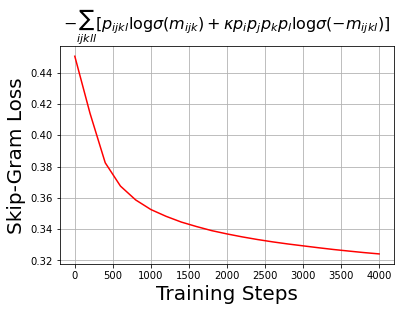

In [19]:
# plot hosgns loss function 

plt.plot(np.arange(len(loss['sg']))*print_every, np.array([t for t in loss['sg']]) ,'r')
plt.grid()
plt.xlabel("Training Steps", fontsize=20)
plt.ylabel("Skip-Gram Loss", fontsize=20)
plt.title(r'$ -\sum_{ijkl}[ p_{ijkl} \log \sigma (m_{ijk}) + \kappa p_ip_jp_kp_l \log \sigma (-m_{ijkl})]$', fontsize=16)

## Node Classification

In [27]:
y = get_infection_label('SIR', 0.125, 0.001, pat_active_time, dataset, AGGR_TIME)
nc_res=[]
for train_test_dict in make_train_test_splits_NC(y, n_splits=30, starting_test_size=0.3, \
                       node_active_list=node_tuple_time, random_state=100):
    emb1_train_idx, emb2_train_idx, y_train_idx = train_test_dict['train']
    emb1_test_idx, emb2_test_idx, y_test_idx = train_test_dict['test']
    
    X_train = emb_W.numpy()[emb1_train_idx]*emb_T.numpy()[emb2_train_idx]
    X_test = emb_W.numpy()[emb1_test_idx]*emb_T.numpy()[emb2_test_idx]
    y_train = y[y_train_idx]
    y_test = y[y_test_idx]
    
    model_clf = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000, n_jobs=6, random_state=100))
    y_test_pred = model_clf.fit(X_train, y_train).predict(X_test)
    nc_res.append(f1_score(y_test, y_test_pred, average='macro'))
print('F1_macro:', np.mean(nc_res), '+-', np.std(nc_res))

F1_macro: 0.609783365528168 +- 0.05558362140265357


## Link Reconstruction

In [26]:
lr_res=[]
for train_test_dict in make_train_test_splits_LR(n_splits=6, starting_test_size=0.3, \
                       node_active_list=node_tuple_time, df_events=df_tnet, random_state=100):
    emb1_train_idx, emb2_train_idx, emb3_train_idx, y_train = train_test_dict['train']
    emb1_test_idx, emb2_test_idx, emb3_test_idx, y_test = train_test_dict['test']
    X_train = emb_W.numpy()[emb1_train_idx]*emb_C.numpy()[emb2_train_idx]\
                *emb_T.numpy()[emb3_train_idx]*emb_S.numpy()[emb3_train_idx]
    X_test = emb_W.numpy()[emb1_test_idx]*emb_C.numpy()[emb2_test_idx]\
                *emb_T.numpy()[emb3_test_idx]*emb_S.numpy()[emb3_test_idx]
    
    model_clf = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000, n_jobs=6, random_state=100))
    y_test_pred = model_clf.fit(X_train, y_train).predict(X_test)
    lr_res.append(f1_score(y_test, y_test_pred, average='macro'))
print('F1_macro:', np.mean(lr_res), '+-', np.std(lr_res))

F1_macro: 0.8205713345549522 +- 0.013561788280833464


## Link Prediction

In [10]:
# load network and default list of active nodes
supra_G = pickle.load(open('../preprocessed/SupraAdjacencyMatrix/%s/Dyn/Aggtime%dWeight1ReptimeNon.gpickle' % (dataset+'_7030_0', AGGR_TIME), 'rb'))
pat_active_time = pickle.load(open('../preprocessed/SupraAdjacencyMatrix/%s/PatActiveTimeAggtime%d.pkl'% (dataset ,AGGR_TIME), 'rb'))
node_active_time = np.array([str(map_node_index[int(n_node.split('-')[0])])+'-'+\
                                 str(map_time_index[int(n_node.split('-')[1])]) for n_node in pat_active_time])
times = [int(x.split('-')[1]) for x in node_active_time]
node_tuple_time = [(int(n_node.split('-')[0]), int(n_node.split('-')[1])) for n_node in node_active_time]

In [11]:
# train 4way-hosgns 
print_every=200
solver = hosgns_walks.HOSGNSSolver(network=supra_G.to_undirected(), 
                         window_size=10,
                         emb_dim=128,
                         order=4,
                         iters=4000,
                         batch_size=20000, 
                         negative_samples=5,
                         learning_rate=tf.keras.optimizers.schedules.PolynomialDecay(0.05, 4000),
                         warmup_steps=1000,
                         random_state=42)
loss = solver.train(print_loss='sg', print_every=print_every)
emb_W, emb_T, emb_C, emb_S = solver.model.factors

Sampling Random Walks...
Warmup...
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Training...
step    0 - loss: 0.4505610466003418 (27.9205 seconds)
step  200 - loss: 0.4138459861278534 (38.8677 seconds)
step  400 - loss: 0.37898558378219604 (36.5471 seconds)
step  600 - loss: 0.36319392919540405 (35.1069 seconds)
step  800 - loss: 0.35400718450546265 (38.5533 seconds)
step 1000 - loss: 0.34787166118621826 (38.3080 seconds)
step 1200 - loss: 0.3432738780975342 (35.9054 seconds)
step 1400 - loss: 0.33967161178588867 (35.6171 seconds)
step 1600 - loss: 0.33674106001853943 (35.7738 seconds)
step 1800 - loss: 0.3343159258365631 (37.0103 seconds)
step 2000 - loss: 0.3322913348674774 (34.2305 seconds)
step 2200 - loss: 0.33043172955513 (36.8444 seconds)
step 2400 - loss: 0.32875069975852966 (36.0171 seconds)
step 2600 - loss: 0.32729747891426086 (35.1550 seconds)
step 2800 - loss: 0.32592958211898804 (

In [12]:
_, _, df_tnet = load_temp_data(dataset, aggr_time=AGGR_TIME)
_, _, df_samp = load_modified_temp_data(dataset, aggr_time=AGGR_TIME)
df_del = df_tnet.loc[df_tnet.merge(df_samp, on=['tslice','i','j'], how='left', suffixes=('','_')).weight_.isnull()].reset_index(drop=True)

df_samp['tslice'] = df_samp['tslice'].map(map_time_index) 
df_samp['i'] = df_samp['i'].map(map_node_index) 
df_samp['j'] = df_samp['j'].map(map_node_index)

df_del['tslice'] = df_del['tslice'].map(map_time_index) 
df_del['i'] = df_del['i'].map(map_node_index) 
df_del['j'] = df_del['j'].map(map_node_index)

In [13]:
df_events = (df_samp, df_del)

lp_res=[]
for train_test_dict in make_train_test_splits_LP(n_splits=6, starting_test_size=0.3, \
                       node_active_list=node_tuple_time, df_events=df_events, random_state=100):
    emb1_train_idx, emb2_train_idx, emb3_train_idx, y_train = train_test_dict['train']
    emb1_test_idx, emb2_test_idx, emb3_test_idx, y_test = train_test_dict['test']
    X_train = emb_W.numpy()[emb1_train_idx]*emb_C.numpy()[emb2_train_idx]\
                *emb_T.numpy()[emb3_train_idx]*emb_S.numpy()[emb3_train_idx]
    X_test = emb_W.numpy()[emb1_test_idx]*emb_C.numpy()[emb2_test_idx]\
                *emb_T.numpy()[emb3_test_idx]*emb_S.numpy()[emb3_test_idx]
    
    model_clf = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000, n_jobs=6, random_state=100))
    y_test_pred = model_clf.fit(X_train, y_train).predict(X_test)
    lp_res.append(f1_score(y_test, y_test_pred, average='macro'))
print('F1_macro:', np.mean(lp_res), '+-', np.std(lp_res))

F1_macro: 0.8181839871297502 +- 0.009654671998388967
